In [1]:
import joblib

#joblib.parallel_backend("threading")

In [2]:
"""
%cd /kaggle/working
#!git clone https://github.com/R-N/ml-utility-loss --depth=1 --single-branch --branch=main
%cd ml-utility-loss
!git pull
#!pip install .
!pip install . --no-deps --force-reinstall --upgrade
#"""

'\n%cd /kaggle/working\n#!git clone https://github.com/R-N/ml-utility-loss --depth=1 --single-branch --branch=main\n%cd ml-utility-loss\n!git pull\n#!pip install .\n!pip install . --no-deps --force-reinstall --upgrade\n#'

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [3,3]

In [4]:
datasets = [
    "insurance",
    "treatment",
    "contraceptive"
]

study_dir = "./"

In [5]:
#Parameters
import os

path_prefix = "../../../../"

dataset_dir = os.path.join(path_prefix, "ml-utility-loss/datasets")
dataset_name = "treatment"
model_name="ml_utility_2"
models = ["tvae", "realtabformer", "lct_gan", "tab_ddpm_concat"]
single_model = "lct_gan"
random_seed = 42
gp = True
gp_multiply = True
folder = "eval"
debug = False
path = None
param_index = 0
allow_same_prediction = True
log_wandb = False

In [6]:
# Parameters
dataset = "treatment"
dataset_name = "treatment"
single_model = "tvae"
gp = True
gp_multiply = True
random_seed = 1
debug = False
folder = "eval"
path_prefix = "../../../../"
path = "eval/treatment/tvae/1"
param_index = 0
allow_same_prediction = True
log_wandb = False


In [7]:
from pathlib import Path
import os

%cd /kaggle/working/

if path is None:
    path = os.path.join(folder, dataset_name, single_model, random_seed)
Path(path).mkdir(parents=True, exist_ok=True)

%cd {path}

/kaggle/working
/kaggle/working/eval/treatment/tvae/1


In [8]:
from ml_utility_loss.util import seed
if single_model:
    model_name=f"{model_name}_{single_model}"
if random_seed is not None:
    seed(random_seed)
    print("Set seed to", seed)

Set seed to <function seed at 0x7da66510f400>


In [9]:
import pandas as pd
import numpy as np
import json
import os

df = pd.read_csv(os.path.join(dataset_dir, f"{dataset_name}.csv"))
with open(os.path.join(dataset_dir, f"{dataset_name}.json")) as f:
    info = json.load(f)

In [10]:
task = info["task"]
target = info["target"]
cat_features = info["cat_features"]
mixed_features = info["mixed_features"]
longtail_features = info["longtail_features"]
integer_features = info["integer_features"]

test = df.sample(frac=0.2, random_state=42)
train = df[~df.index.isin(test.index)]

In [11]:
import ml_utility_loss.synthesizers.tab_ddpm.params as TAB_DDPM_PARAMS
import ml_utility_loss.synthesizers.lct_gan.params as LCT_GAN_PARAMS
import ml_utility_loss.synthesizers.realtabformer.params as RTF_PARAMS
from ml_utility_loss.synthesizers.realtabformer.params.default import GPT2_PARAMS, REALTABFORMER_PARAMS
from ml_utility_loss.util import filter_dict_2, filter_dict

tab_ddpm_params = getattr(TAB_DDPM_PARAMS, dataset_name).BEST
lct_gan_params = getattr(LCT_GAN_PARAMS, dataset_name).BEST
lct_ae_params = filter_dict_2(lct_gan_params, LCT_GAN_PARAMS.default.AE_PARAMS)
rtf_params = getattr(RTF_PARAMS, dataset_name).BEST
rtf_params = filter_dict(rtf_params, REALTABFORMER_PARAMS)

lct_ae_embedding_size=lct_gan_params["embedding_size"]
tab_ddpm_normalization="quantile"
tab_ddpm_cat_encoding=tab_ddpm_params["cat_encoding"]
#tab_ddpm_cat_encoding="one-hot"
tab_ddpm_y_policy="default"
tab_ddpm_is_y_cond=True

In [12]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_lct_ae

lct_ae = load_lct_ae(
    dataset_name=dataset_name,
    model_dir=os.path.join(path_prefix, "ml-utility-loss/models"),
    model_name="lct_ae",
    df_name="df",
)
lct_ae = None

2024-03-26 11:11:26.605320: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 11:11:26.605381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 11:11:26.607182: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_rtf_embed

rtf_embed = load_rtf_embed(
    dataset_name=dataset_name,
    model_dir=os.path.join(path_prefix, "ml-utility-loss/models"),
    model_name="realtabformer",
    df_name="df",
    ckpt_type="best-disc-model"
)

In [14]:
from ml_utility_loss.loss_learning.estimator.preprocessing import DataPreprocessor

preprocessor = DataPreprocessor(
    task,
    target=target,
    cat_features=cat_features,
    mixed_features=mixed_features,
    longtail_features=longtail_features,
    integer_features=integer_features,
    lct_ae_embedding_size=lct_ae_embedding_size,
    lct_ae_params=lct_ae_params,
    lct_ae=lct_ae,
    tab_ddpm_normalization=tab_ddpm_normalization,
    tab_ddpm_cat_encoding=tab_ddpm_cat_encoding,
    tab_ddpm_y_policy=tab_ddpm_y_policy,
    tab_ddpm_is_y_cond=tab_ddpm_is_y_cond,
    realtabformer_embedding=rtf_embed,
    realtabformer_params=rtf_params,
)
preprocessor.fit(df)

/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
preprocessor.adapter_sizes

{'tvae': 95,
 'realtabformer': (69, 281, Embedding(281, 768), True),
 'lct_gan': 75,
 'tab_ddpm_concat': 12}

In [16]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_dataset_4

test_set = load_dataset_4(
    dataset_dir=os.path.join(path_prefix, "ml-utility-loss/"),
    dataset_name=dataset_name,
    preprocessor=preprocessor,
    model=single_model,
    cache_dir=path_prefix,
)

Caching in ../../../../treatment/_cache_aug_test/tvae/all inf False
../../../../ml-utility-loss/aug_test/treatment 0
Caching in ../../../../treatment/_cache_bs_test/tvae/all inf False
../../../../ml-utility-loss/bs_test/treatment 0
Caching in ../../../../treatment/_cache_synth_test/tvae/all inf False
../../../../ml-utility-loss/synthetics/treatment 600
600


In [17]:
import ml_utility_loss.loss_learning.estimator.params2 as PARAMS
from ml_utility_loss.tuning import map_parameters
from ml_utility_loss.loss_learning.estimator.params.default import update_param_space, update_param_space_2
import wandb

#"""
param_space = {
    **getattr(PARAMS, dataset_name).PARAM_SPACE,
}
# params = {
#     **getattr(PARAMS, dataset_name).BESTS[param_index],
# }
params = getattr(PARAMS, dataset_name).BEST_DICT[gp][gp_multiply][single_model]
params = {
    **getattr(PARAMS, dataset_name).DEFAULTS,
    **params,
}
if isinstance(params, (list, tuple)):
    params = params[param_index]
if gp:
    params["gradient_penalty_mode"] = "ALL"
    params["mse_mag"] = True
    if gp_multiply:
        params["mse_mag_multiply"] = True
        #params["mse_mag_target"] = 1.0
    else:
        params["mse_mag_multiply"] = False
        #params["mse_mag_target"] = 0.1
else:
    params["gradient_penalty_mode"] = "NONE"
    params["mse_mag"] = False
params["single_model"] = False
if models:
    params["models"] = models
if single_model:
    params["fixed_role_model"] = single_model
    params["single_model"] = True
    params["models"] = [single_model]
if params["fixed_role_model"] == "realtabformer" and dataset_name == "treatment":
    params["batch_size"] = 2
params["max_seconds"] = 3600
params["patience"] = 10
params["epochs"] = 100
if debug:
    params["epochs"] = 2
with open("params.json", "w") as f:
    json.dump(params, f)
params = map_parameters(params, param_space=param_space)
params

{'Body': 'twin_encoder',
 'loss_balancer_meta': True,
 'loss_balancer_log': False,
 'loss_balancer_lbtw': False,
 'pma_skip_small': False,
 'isab_skip_small': False,
 'layer_norm': False,
 'pma_layer_norm': False,
 'attn_residual': True,
 'tf_n_layers_dec': False,
 'tf_isab_rank': 0,
 'tf_layer_norm': False,
 'tf_pma_start': -1,
 'head_n_seeds': 0,
 'tf_pma_low': 16,
 'dropout': 0,
 'combine_mode': 'diff_left',
 'tf_isab_mode': 'separate',
 'grad_loss_fn': <function torch.nn.functional.l1_loss(input: torch.Tensor, target: torch.Tensor, size_average: Optional[bool] = None, reduce: Optional[bool] = None, reduction: str = 'mean') -> torch.Tensor>,
 'single_model': True,
 'bias': True,
 'bias_final': True,
 'pma_ffn_mode': 'none',
 'patience': 10,
 'inds_init_mode': 'torch',
 'grad_clip': 0.75,
 'gradient_penalty_mode': {'gradient_penalty': True,
  'forward_once': False,
  'calc_grad_m': False,
  'avg_non_role_model_m': False,
  'inverse_avg_non_role_model_m': False},
 'synth_data': 2,
 'b

In [18]:
from ml_utility_loss.loss_learning.estimator.model.pipeline import remove_non_model_params
from ml_utility_loss.loss_learning.estimator.pipeline import create_model
from ml_utility_loss.util import filter_dict, clear_memory

clear_memory()

params2 = remove_non_model_params(params)
adapters = filter_dict(preprocessor.adapter_sizes, params["models"])

model = create_model(
    adapters=adapters,
    #Body="twin_encoder",
    **params2,
)
#cf.apply_weight_standardization(model, n_last_layers_ignore=0)
print(model.models, len(model.adapters))

Creating model of type <class 'ml_utility_loss.loss_learning.estimator.model.models.TwinEncoder'>
[*] Embedding False True


['tvae'] 1


In [19]:
study_name=f"{model_name}_{dataset_name}"

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

29729665

In [21]:
from torchinfo import summary

role_model = params["fixed_role_model"]
s = test_set[0][role_model]
summary(model[role_model], input_size=((2, *s[0].shape), (2, *s[1].shape)), depth=9) # 8 max

Layer (type:depth-idx)                                                 Output Shape              Param #
MLUtilitySingle                                                        [2, 2648, 95]             --
├─Adapter: 1-1                                                         [2, 2648, 95]             --
│    └─Sequential: 2-1                                                 [2, 2648, 512]            --
│    │    └─FeedForward: 3-1                                           [2, 2648, 2048]           --
│    │    │    └─Linear: 4-1                                           [2, 2648, 2048]           196,608
│    │    │    └─LeakyHardtanh: 4-2                                    [2, 2648, 2048]           --
│    │    └─FeedForward: 3-2                                           [2, 2648, 2048]           --
│    │    │    └─Linear: 4-3                                           [2, 2648, 2048]           4,196,352
│    │    │    └─LeakyHardtanh: 4-4                                    [2, 2648, 20

In [22]:
import torch
model.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

In [23]:

from ml_utility_loss.loss_learning.estimator.pipeline import eval
#eval_loss = loss["eval_loss"]

batch_size = params["batch_size_low"] if "batch_size_low" in params else params["batch_size"]

eval_loss = eval(
    test_set, model,
    batch_size=batch_size,
)

In [24]:
import pandas as pd

metrics = pd.DataFrame(eval_loss["model_metrics"]).T
metrics.to_csv("eval.csv")
metrics

avg_g_cos_loss  avg_g_mag_loss  avg_loss  grad_duration  grad_mae  \
tvae             0.0            0.24  0.004334       5.680646  0.061749   

      grad_mape  grad_rmse  mean_pred_loss  pred_duration  pred_mae  \
tvae   1.489419   0.096514          0.0002       7.251855  0.039978   

      pred_mape  pred_rmse  pred_std  std_loss  total_duration  
tvae  256361.25   0.065836  0.219951  0.000023       12.932501

In [25]:
from ml_utility_loss.util import clear_memory
clear_memory()

In [26]:
#"""
from ml_utility_loss.loss_learning.estimator.process import pred, pred_2
from ml_utility_loss.util import stack_samples

#samples = test_set[list(range(len(test_set)))]
#y = {m: pred(model[m], s) for m, s in samples.items()}
y = pred_2(model, test_set, batch_size=batch_size)
#"""

Caching in ../../../../treatment/_cache_aug_test/tvae/all inf False
Caching in ../../../../treatment/_cache_bs_test/tvae/all inf False
Caching in ../../../../treatment/_cache_synth_test/tvae/all inf False


In [27]:
import os
import pandas as pd
from ml_utility_loss.util import transpose_dict

os.makedirs("pred", exist_ok=True)
y2 = transpose_dict(y)
for k, v in y2.items():
    df = pd.DataFrame(v)
    df.to_csv(f"pred/{k}.csv")

In [28]:
print({k: sum(v["pred"])/len(v["pred"]) for k, v in y.items()})

{'tvae': 0.46125430537475043}


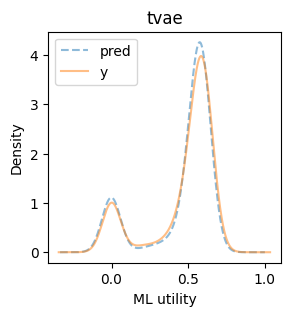

In [29]:
from ml_utility_loss.loss_learning.visualization import plot_pred_density_2

_ = plot_pred_density_2(y)

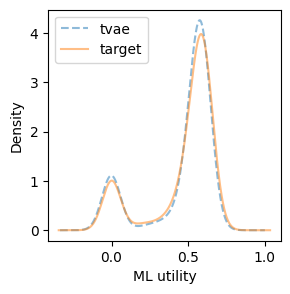

In [30]:
from ml_utility_loss.loss_learning.visualization import plot_density_3

_ = plot_density_3(y2["pred"], next(iter(y2["y"].values())))

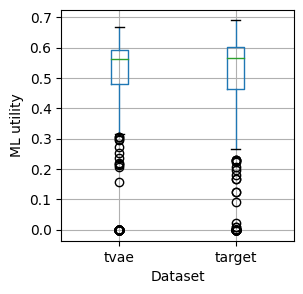

In [31]:
from ml_utility_loss.loss_learning.visualization import plot_box_3

_ = plot_box_3(y2["pred"], next(iter(y2["y"].values())))

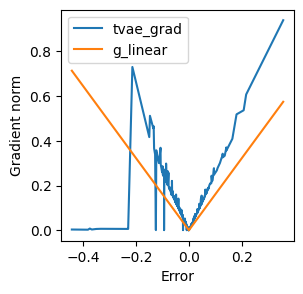

In [32]:
#"""
from ml_utility_loss.loss_learning.visualization import plot_grad, plot_grad_2, plot_grad_3
import matplotlib.pyplot as plt

#plot_grad_2(y, model.models)
for m in model.models:
    ym = y[m]
    fig, ax = plt.subplots()
    plot_grad_3(ym["error"], ym["grad"], name=f"{m}_grad", fig=fig, ax=ax)
#"""